In [11]:
import psycopg2
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')

In [2]:
from get_clean_data_LinReg import get_data, clean_data, get_feats, get_target

In [3]:
with open('form5500_data/config.json') as f:
    conf = json.load(f)
    host = conf['host']
    database = conf['database']
    user = conf['user']
    passw = conf['passw']
conn_str = "host={} dbname={} user={} password={}".format(host, database, user, passw)
conn = psycopg2.connect(conn_str)

In [4]:
query = '''SELECT sb.SB_EIN, sb.SB_PN, sb.SB_PLAN_TYPE_CODE,
       sb.SB_TOT_PARTCP_CNT, sb.SB_ACT_PARTCP_CNT, SB_TERM_PARTCP_CNT, SB_RTD_PARTCP_CNT,
       sb.SB_TOT_FNDNG_TGT_AMT, SB_LIAB_ACT_TOT_FNDNG_TGT_AMT, SB_TERM_FNDNG_TGT_AMT, SB_RTD_FNDNG_TGT_AMT,
       f.PLAN_NAME, f.SPONSOR_DFE_NAME
       FROM sb_full sb 
       LEFT JOIN f5500_full f 
       ON sb.SB_EIN = f.SPONS_DFE_EIN AND sb.SB_PN = f.SPONS_DFE_PN 
       WHERE sb.SB_PLAN_YEAR_BEGIN_DATE = '2014-01-01'
       AND sb.SB_PLAN_TYPE_CODE = '1';'''

In [5]:
df = pd.read_sql(query, con=conn)
conn.close()

<h3>Convert object counts to numeric</h3>

In [6]:
clean_list = ['sb_tot_partcp_cnt', 'sb_act_partcp_cnt','sb_term_partcp_cnt', 'sb_rtd_partcp_cnt']

for c in clean_list:
    df[c] = pd.to_numeric(df[c])

<h3>Drop largest plan</h3>

In [7]:
df = df.loc[df['sb_tot_partcp_cnt'] != df['sb_tot_partcp_cnt'].max()]

<h3>Remove plans with $0 funding target or 0 participnat count</h3>

In [8]:
df = df[(df['sb_tot_fndng_tgt_amt']>0) & (df['sb_tot_partcp_cnt'] > 0)]

In [48]:
df['sb_tot_partcp_cnt'].max()

981260.0

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sb_ein,92013.0,4.342832e+08,2.797733e+08,10020240.0,208457967.0,363855659.0,630353833.0,9.903821e+08
sb_pn,92013.0,6.422690e+00,2.813793e+01,1.0,1.0,2.0,3.0,4.610000e+02
sb_tot_partcp_cnt,92013.0,2.385292e+03,1.556673e+04,1.0,6.0,129.0,743.0,9.812600e+05
sb_act_partcp_cnt,91749.0,8.619018e+02,6.655837e+03,0.0,4.0,31.0,236.0,4.637120e+05
sb_term_partcp_cnt,91273.0,6.906531e+02,4.068782e+03,0.0,1.0,28.0,225.0,1.506690e+05
sb_rtd_partcp_cnt,90840.0,8.516210e+02,8.915223e+03,0.0,0.0,16.0,201.0,9.812510e+05
sb_tot_fndng_tgt_amt,92013.0,1.469603e+08,1.029371e+09,1.0,862434.0,4466835.0,34868621.0,4.587275e+10
sb_liab_act_tot_fndng_tgt_amt,91725.0,5.193538e+07,3.506713e+08,0.0,561168.0,1903485.0,11808608.0,1.628913e+10
sb_term_fndng_tgt_amt,91218.0,2.196949e+07,1.462229e+08,0.0,381.0,578792.0,5932793.0,7.070183e+09
sb_rtd_fndng_tgt_amt,90765.0,7.441712e+07,6.101019e+08,0.0,0.0,1038644.0,13648116.0,2.962763e+10


<h1>Distribution of Plans by Percentile of Participant Count</h1>

<h3>All Plans</h3>

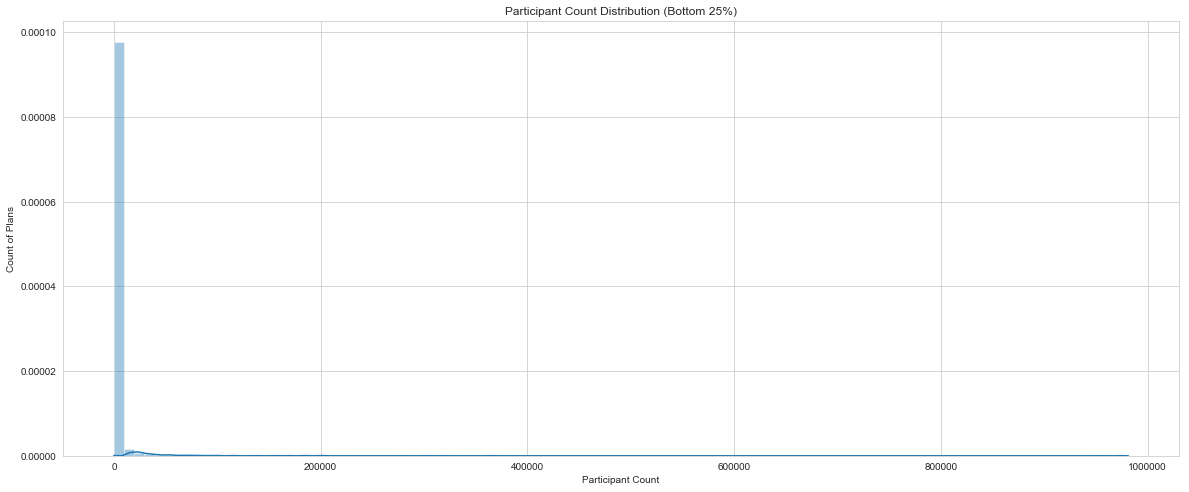

In [12]:
fig, ax = plt.subplots(1,1,figsize=(20,8))
ax = sns.distplot(df['sb_tot_partcp_cnt'], bins=100)
plt.title('Participant Count Distribution (Bottom 25%)')
plt.xlabel('Participant Count')
plt.ylabel('Count of Plans')
plt.show()

Lots of very small plans!

<h3>Bottom 25th %-ile based on participant count</h3>

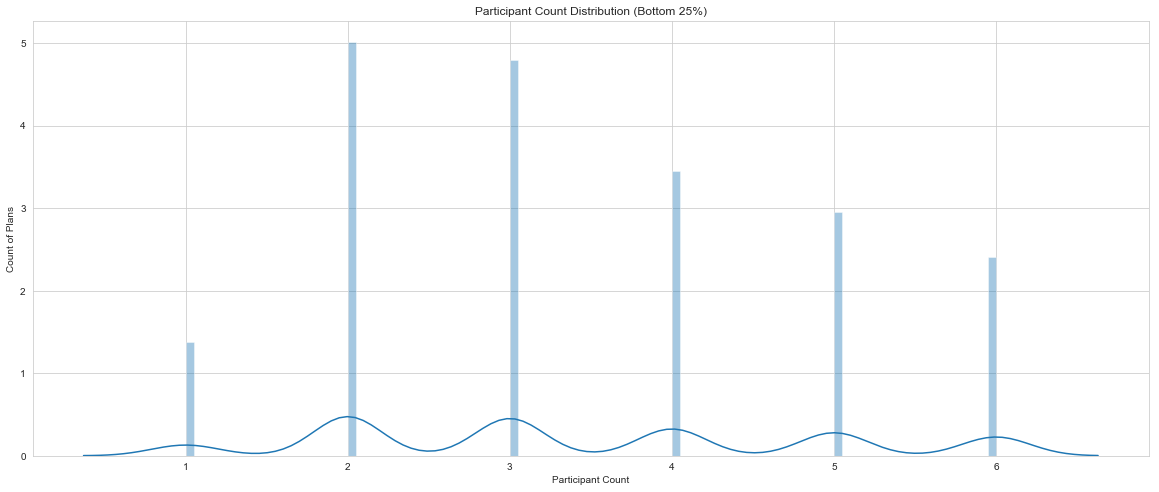

In [14]:
fig, ax = plt.subplots(1,1,figsize=(20,8))
ax = sns.distplot(df[df['sb_tot_partcp_cnt'] <= df['sb_tot_partcp_cnt'].quantile(.25)]['sb_tot_partcp_cnt'], bins=100)
plt.title('Participant Count Distribution (Bottom 25%)')
plt.xlabel('Participant Count')
plt.ylabel('Count of Plans')
plt.show()

All plans in the bottom 25th percentile have 6 or fewer plan participants

<h3>25th - 50th %-ile based on participant count</h3>

In [ ]:
df[(df['sb_tot_partcp_cnt'] > df['sb_tot_partcp_cnt'].quantile(.25)) & (df['sb_tot_partcp_cnt'] <= df['sb_tot_partcp_cnt'].quantile(.50))]

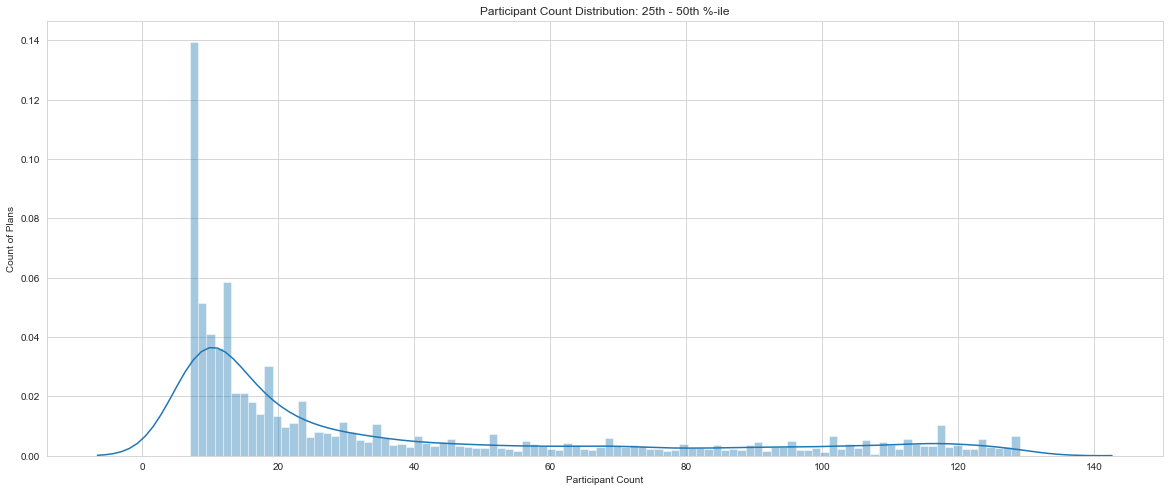

In [15]:
fig, ax = plt.subplots(1,1,figsize=(20,8))
ax = sns.distplot(df[(df['sb_tot_partcp_cnt'] > df['sb_tot_partcp_cnt'].quantile(.25)) & (df['sb_tot_partcp_cnt'] <= df['sb_tot_partcp_cnt'].quantile(.50))]['sb_tot_partcp_cnt'], bins=100)
plt.title('Participant Count Distribution: 25th - 50th %-ile')
plt.xlabel('Participant Count')
plt.ylabel('Count of Plans')
plt.show()

Still lots of plans with 20 or fewer participants in 25th - 50th %-ile

<h3>50th - 75th %-ile based on participant count</h3>

In [ ]:
df[(df['sb_tot_partcp_cnt'] > df['sb_tot_partcp_cnt'].quantile(.5)) & (df['sb_tot_partcp_cnt'] <= df['sb_tot_partcp_cnt'].quantile(.75))]

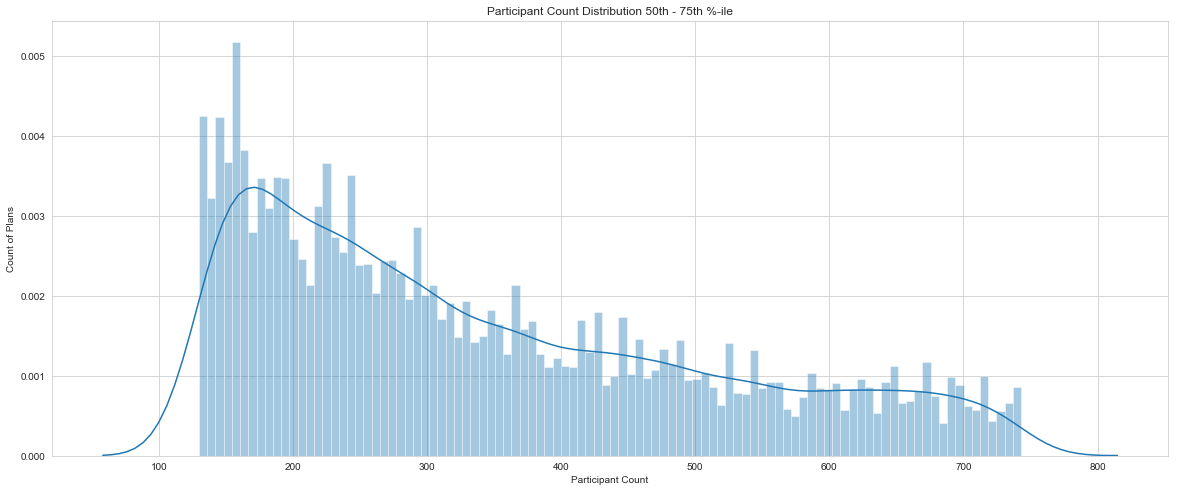

In [16]:
fig, ax = plt.subplots(1,1,figsize=(20,8))
ax = sns.distplot(df[(df['sb_tot_partcp_cnt'] > df['sb_tot_partcp_cnt'].quantile(.5)) & (df['sb_tot_partcp_cnt'] <= df['sb_tot_partcp_cnt'].quantile(.75))]['sb_tot_partcp_cnt'], bins=100)
plt.title('Participant Count Distribution 50th - 75th %-ile')
plt.xlabel('Participant Count')
plt.ylabel('Count of Plans')
plt.show()

<h3>75th - 90th %-ile by plan participant count</h3>

In [ ]:
df[(df['sb_tot_partcp_cnt'] > df['sb_tot_partcp_cnt'].quantile(.75)) & (df['sb_tot_partcp_cnt'] <= df['sb_tot_partcp_cnt'].quantile(.90))] 
   #& df['sb_tot_partcp_cnt'] <= df['sb_tot_partcp_cnt'].quantile(.9)]

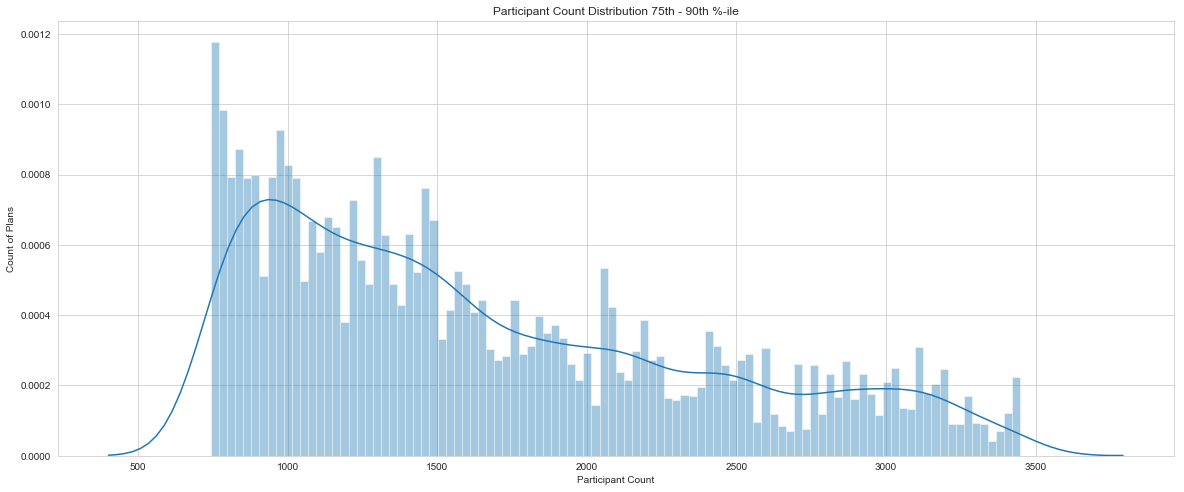

In [17]:
fig, ax = plt.subplots(1,1,figsize=(20,8))
ax = sns.distplot(df[(df['sb_tot_partcp_cnt'] > df['sb_tot_partcp_cnt'].quantile(.75)) & (df['sb_tot_partcp_cnt'] <= df['sb_tot_partcp_cnt'].quantile(.9))]['sb_tot_partcp_cnt'], bins=100)
plt.title('Participant Count Distribution 75th - 90th %-ile')
plt.xlabel('Participant Count')
plt.ylabel('Count of Plans')
plt.show()

<h3>90th - 95th %-ile</h3>

In [ ]:
df[(df['sb_tot_partcp_cnt'] > df['sb_tot_partcp_cnt'].quantile(.90)) & (df['sb_tot_partcp_cnt'] <= df['sb_tot_partcp_cnt'].quantile(.95))]

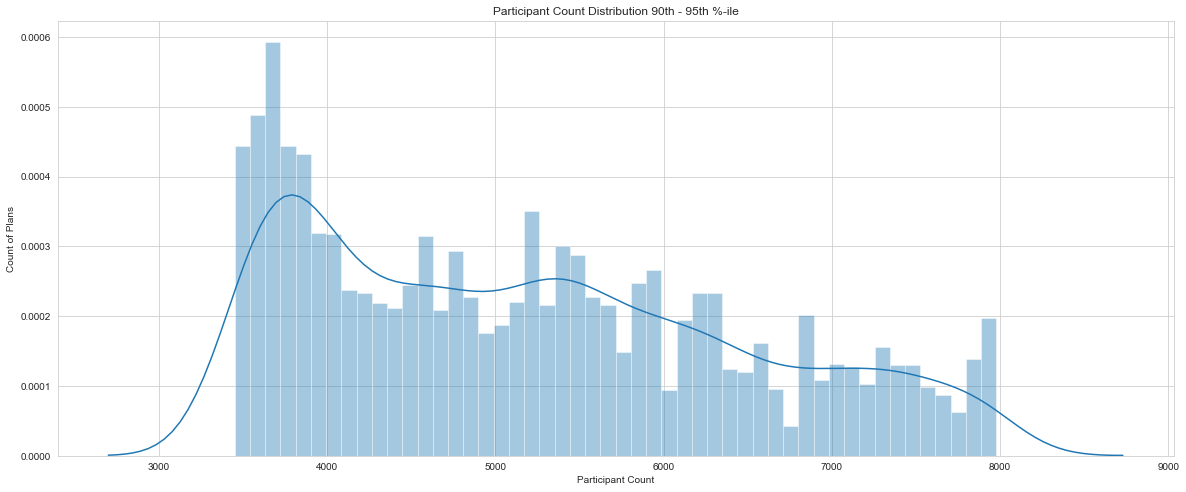

In [18]:
fig, ax = plt.subplots(1,1,figsize=(20,8))
ax = sns.distplot(df[(df['sb_tot_partcp_cnt'] > df['sb_tot_partcp_cnt'].quantile(.90)) & (df['sb_tot_partcp_cnt'] <= df['sb_tot_partcp_cnt'].quantile(.95))]['sb_tot_partcp_cnt'], bins=50)
plt.title('Participant Count Distribution 90th - 95th %-ile')
plt.xlabel('Participant Count')
plt.ylabel('Count of Plans')
plt.show()

<h3>95th - 99th %-ile</h3>

In [ ]:
df[df['sb_tot_partcp_cnt'] > df['sb_tot_partcp_cnt'].quantile(.95)]

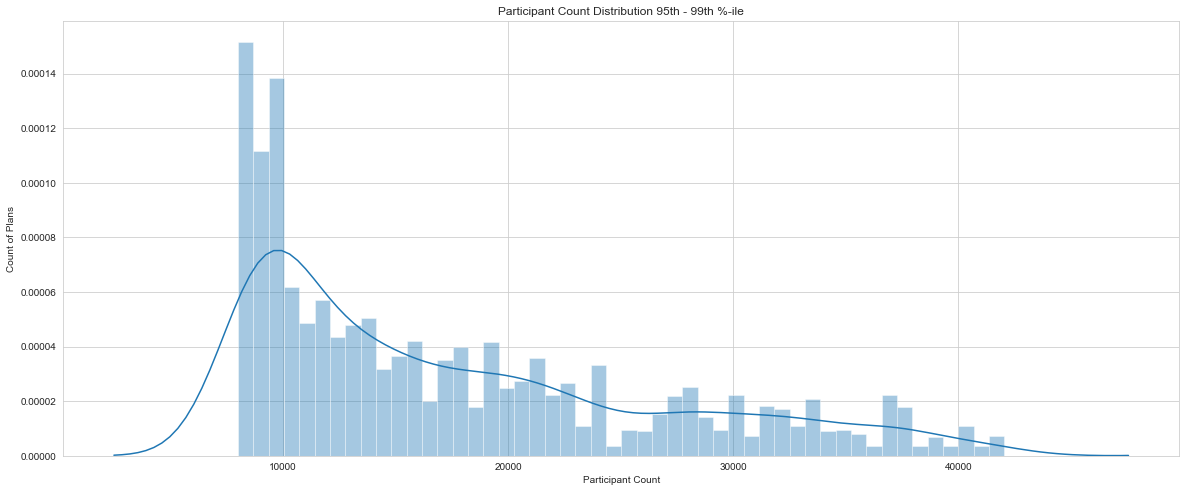

In [19]:
fig, ax = plt.subplots(1,1,figsize=(20,8))
ax = sns.distplot(df[(df['sb_tot_partcp_cnt'] > df['sb_tot_partcp_cnt'].quantile(.95)) & (df['sb_tot_partcp_cnt'] <= df['sb_tot_partcp_cnt'].quantile(.99))]['sb_tot_partcp_cnt'], bins=50)
plt.title('Participant Count Distribution 95th - 99th %-ile')
plt.xlabel('Participant Count')
plt.ylabel('Count of Plans')
plt.show()

<h3>Top 1%</h3>

In [ ]:
df[df['sb_tot_partcp_cnt'] > df['sb_tot_partcp_cnt'].quantile(.99)].describe()

<h3>99th %-ile</h3>

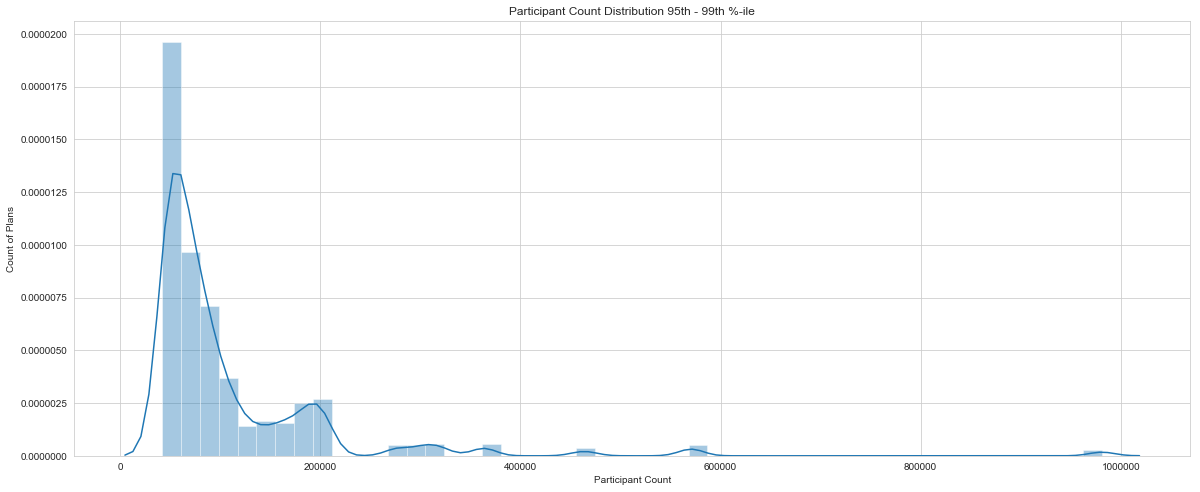

In [20]:
fig, ax = plt.subplots(1,1,figsize=(20,8))
ax = sns.distplot(df[(df['sb_tot_partcp_cnt'] > df['sb_tot_partcp_cnt'].quantile(.99))]['sb_tot_partcp_cnt'], bins=50)
plt.title('Participant Count Distribution 95th - 99th %-ile')
plt.xlabel('Participant Count')
plt.ylabel('Count of Plans')
plt.show()

Several VERY large plans at the right tail

In [21]:
df[df['sb_tot_partcp_cnt'] > 250000].describe()

,sb_ein,sb_pn,sb_tot_partcp_cnt,sb_act_partcp_cnt,sb_term_partcp_cnt,sb_rtd_partcp_cnt,sb_tot_fndng_tgt_amt,sb_liab_act_tot_fndng_tgt_amt,sb_term_fndng_tgt_amt,sb_rtd_fndng_tgt_amt
count,5.800000e+01,58.000000,58.000000,58.000000,58.000000,58.000000,5.800000e+01,5.800000e+01,5.800000e+01,5.800000e+01
mean,2.886884e+08,2.000000,428325.189655,171026.310345,88708.327586,168590.551724,1.799781e+10,5.340666e+09,3.151567e+09,9.505574e+09
std,1.800460e+08,1.777047,197949.447723,125672.827152,52609.250539,261673.260885,1.769389e+10,5.204111e+09,2.262878e+09,1.146367e+10
min,2.071750e+07,1.000000,276687.000000,9.000000,0.000000,0.000000,3.211640e+05,3.187320e+05,0.000000e+00,0.000000e+00
25%,1.343472e+08,1.000000,301331.000000,118781.000000,79192.000000,45661.000000,8.184094e+09,3.358769e+09,2.266610e+09,2.307186e+09
50%,2.026310e+08,1.000000,362828.000000,142497.000000,103105.000000,70145.000000,9.162845e+09,3.838986e+09,2.848836e+09,2.558715e+09
75%,4.313019e+08,2.000000,463714.000000,230036.000000,127941.000000,165785.000000,4.092498e+10,6.922988e+09,4.374369e+09,2.251344e+10
max,5.609066e+08,6.000000,981260.000000,463712.000000,150669.000000,981251.000000,4.587275e+10,1.628913e+10,7.070183e+09,2.962763e+10


<h1>Distribution of Plans by Participant Count</h1>

In [22]:
len(df)

92013

<h3>Distribution of plans with 50 or fewer participants</h3>

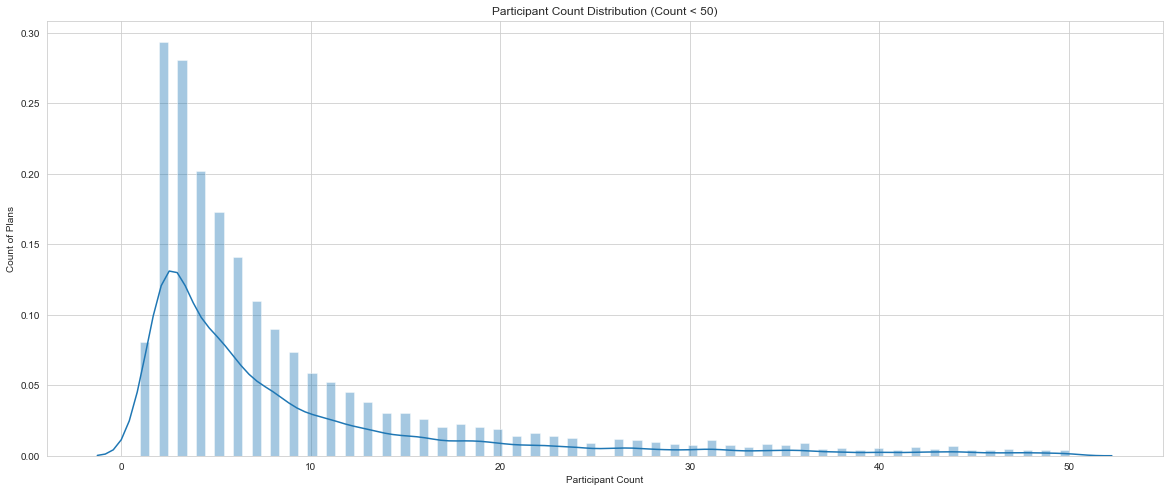

In [23]:
fig, ax = plt.subplots(1,1,figsize=(20,8))
ax = sns.distplot(df[df['sb_tot_partcp_cnt'] <= 50]['sb_tot_partcp_cnt'], bins=100)
plt.title('Participant Count Distribution (Count < 50)')
plt.xlabel('Participant Count')
plt.ylabel('Count of Plans')
plt.show()

In [24]:
len(df[df['sb_tot_partcp_cnt'] <= 50])

40116

<h3>Distribution of plans with between 50 and 300 plan participants</h3>

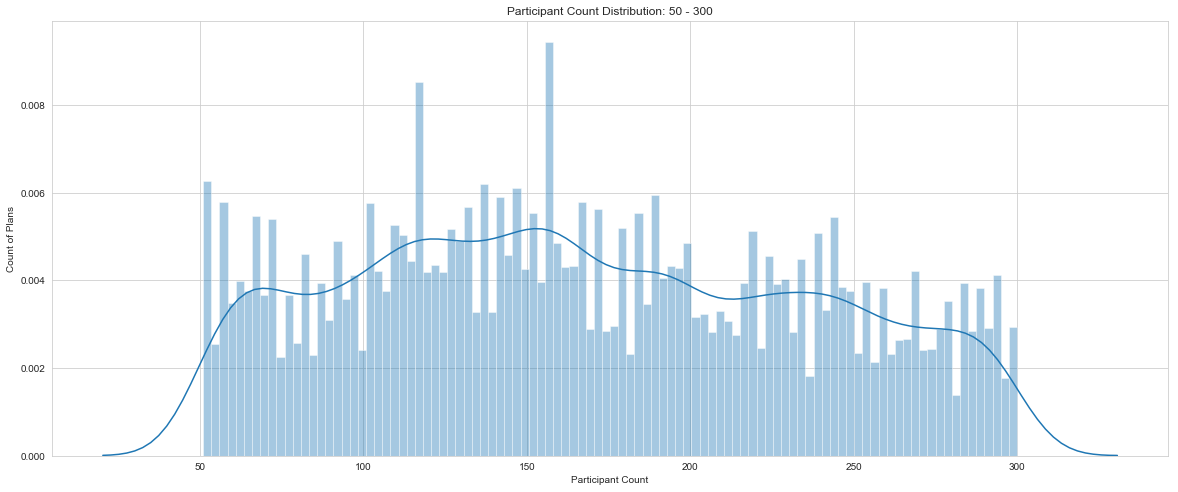

In [25]:
fig, ax = plt.subplots(1,1,figsize=(20,8))
ax = sns.distplot(df[(df['sb_tot_partcp_cnt'] > 50) & (df['sb_tot_partcp_cnt'] <= 300)]['sb_tot_partcp_cnt'], bins=100)
plt.title('Participant Count Distribution: 50 - 300')
plt.xlabel('Participant Count')
plt.ylabel('Count of Plans')
plt.show()

In [26]:
len(df[(df['sb_tot_partcp_cnt'] > 50) & (df['sb_tot_partcp_cnt'] <= 300)])

17771

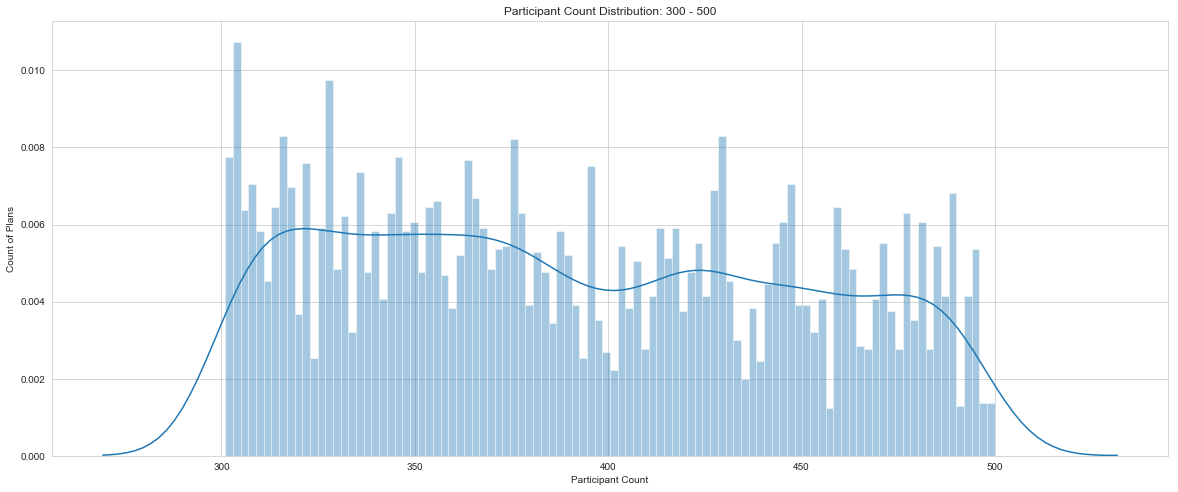

In [27]:
fig, ax = plt.subplots(1,1,figsize=(20,8))
ax = sns.distplot(df[(df['sb_tot_partcp_cnt'] > 300) & (df['sb_tot_partcp_cnt'] <= 500)]['sb_tot_partcp_cnt'], bins=100)
plt.title('Participant Count Distribution: 300 - 500')
plt.xlabel('Participant Count')
plt.ylabel('Count of Plans')
plt.show()

In [28]:
len(df[(df['sb_tot_partcp_cnt'] > 300) & (df['sb_tot_partcp_cnt'] <= 500)])

6547

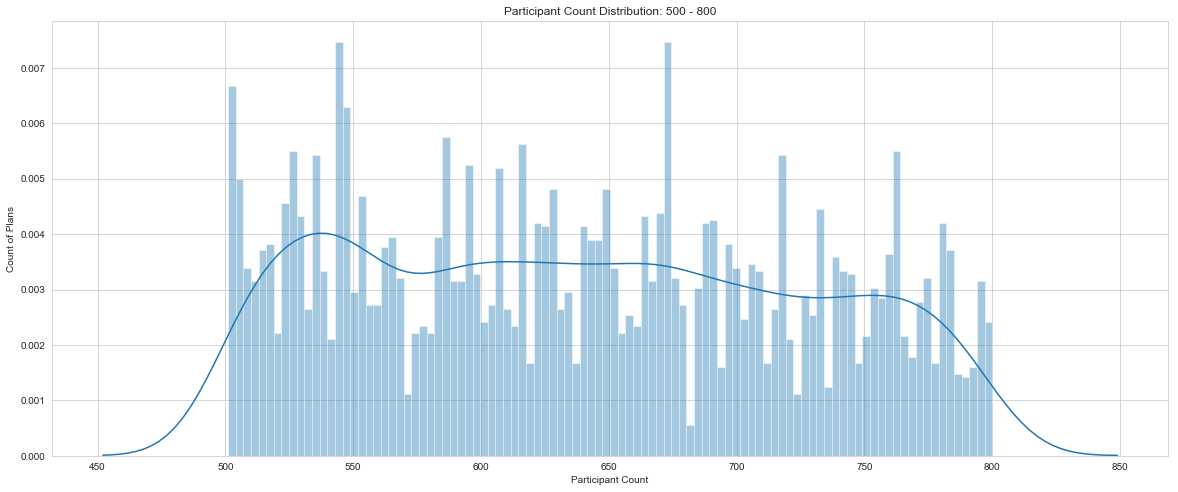

In [29]:
fig, ax = plt.subplots(1,1,figsize=(20,8))
ax = sns.distplot(df[(df['sb_tot_partcp_cnt'] > 500) & (df['sb_tot_partcp_cnt'] <= 800)]['sb_tot_partcp_cnt'], bins=100)
plt.title('Participant Count Distribution: 500 - 800')
plt.xlabel('Participant Count')
plt.ylabel('Count of Plans')
plt.show()

In [30]:
len(df[(df['sb_tot_partcp_cnt'] > 500) & (df['sb_tot_partcp_cnt'] <= 800)])

5416

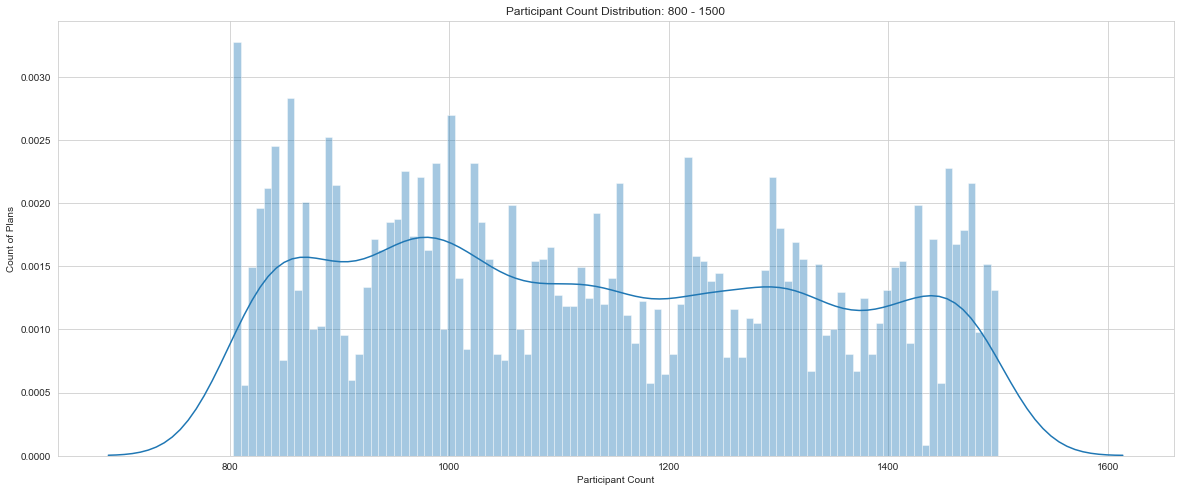

In [31]:
fig, ax = plt.subplots(1,1,figsize=(20,8))
ax = sns.distplot(df[(df['sb_tot_partcp_cnt'] > 800) & (df['sb_tot_partcp_cnt'] <= 1500)]['sb_tot_partcp_cnt'], bins=100)
plt.title('Participant Count Distribution: 800 - 1500')
plt.xlabel('Participant Count')
plt.ylabel('Count of Plans')
plt.show()

In [32]:
len(df[(df['sb_tot_partcp_cnt'] > 800) & (df['sb_tot_partcp_cnt'] <= 1500)])

6435

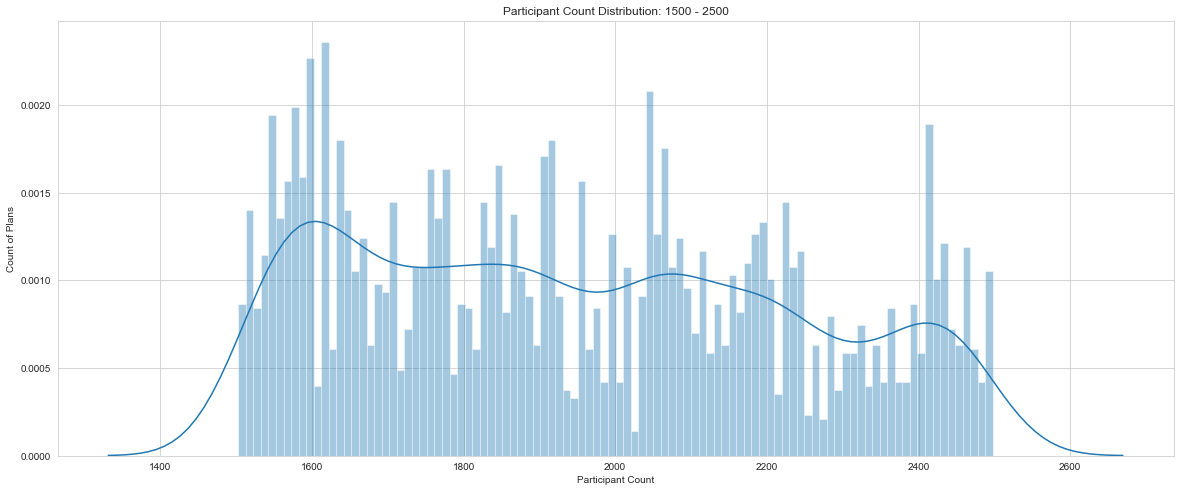

In [33]:
fig, ax = plt.subplots(1,1,figsize=(20,8))
ax = sns.distplot(df[(df['sb_tot_partcp_cnt'] > 1500) & (df['sb_tot_partcp_cnt'] <= 2500)]['sb_tot_partcp_cnt'], bins=100)
plt.title('Participant Count Distribution: 1500 - 2500')
plt.xlabel('Participant Count')
plt.ylabel('Count of Plans')
plt.show()

In [34]:
len(df[(df['sb_tot_partcp_cnt'] > 1500) & (df['sb_tot_partcp_cnt'] <= 2500)])

4297

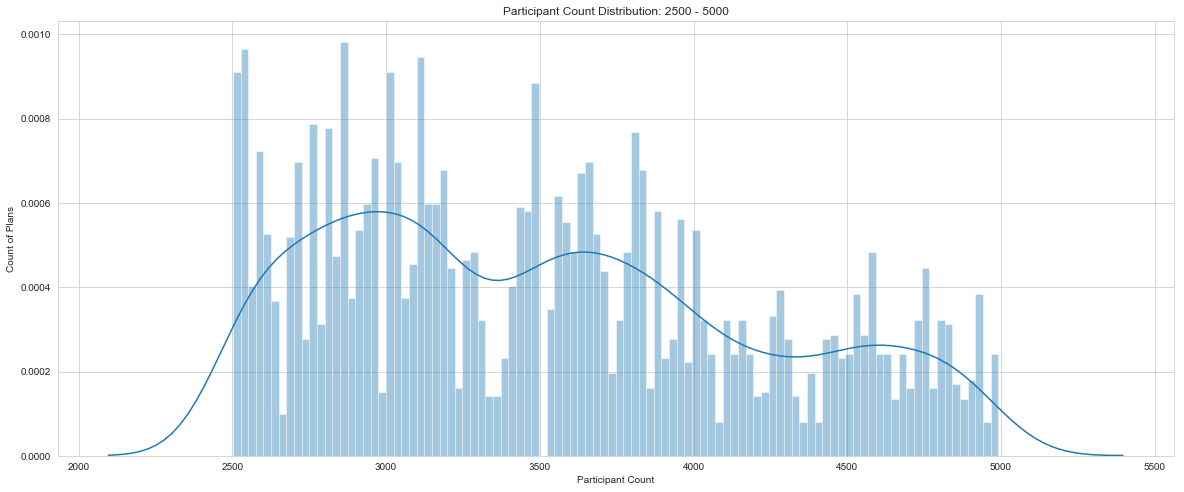

In [35]:
fig, ax = plt.subplots(1,1,figsize=(20,8))
ax = sns.distplot(df[(df['sb_tot_partcp_cnt'] > 2500) & (df['sb_tot_partcp_cnt'] <= 5000)]['sb_tot_partcp_cnt'], bins=100)
plt.title('Participant Count Distribution: 2500 - 5000')
plt.xlabel('Participant Count')
plt.ylabel('Count of Plans')
plt.show()

In [36]:
len(df[(df['sb_tot_partcp_cnt'] > 2500) & (df['sb_tot_partcp_cnt'] <= 5000)])

4497

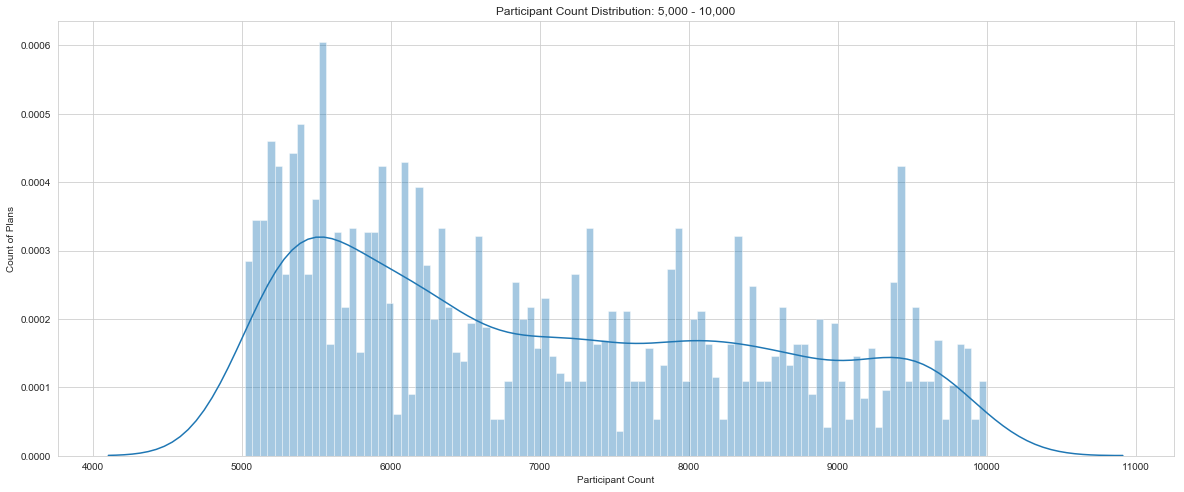

In [37]:
fig, ax = plt.subplots(1,1,figsize=(20,8))
ax = sns.distplot(df[(df['sb_tot_partcp_cnt'] > 5000) & (df['sb_tot_partcp_cnt'] <= 10000)]['sb_tot_partcp_cnt'], bins=100)
plt.title('Participant Count Distribution: 5,000 - 10,000')
plt.xlabel('Participant Count')
plt.ylabel('Count of Plans')
plt.show()

In [38]:
len(df[(df['sb_tot_partcp_cnt'] > 5000) & (df['sb_tot_partcp_cnt'] <= 10000)])

3320

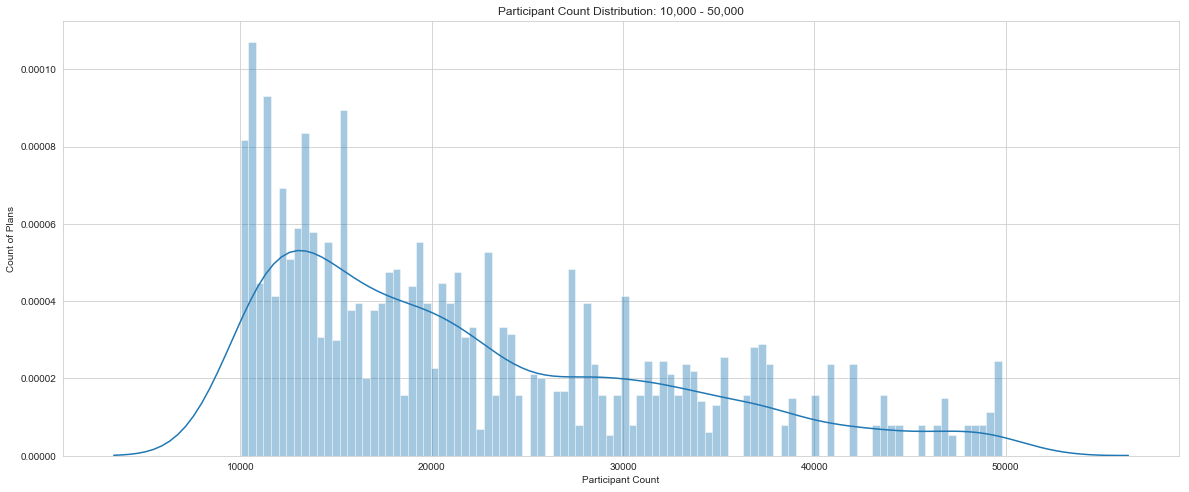

In [39]:
fig, ax = plt.subplots(1,1,figsize=(20,8))
ax = sns.distplot(df[(df['sb_tot_partcp_cnt'] > 10000) & (df['sb_tot_partcp_cnt'] <= 50000)]['sb_tot_partcp_cnt'], bins=100)
plt.title('Participant Count Distribution: 10,000 - 50,000')
plt.xlabel('Participant Count')
plt.ylabel('Count of Plans')
plt.show()

In [40]:
len(df[(df['sb_tot_partcp_cnt'] > 10000) & (df['sb_tot_partcp_cnt'] <= 50000)])

2863

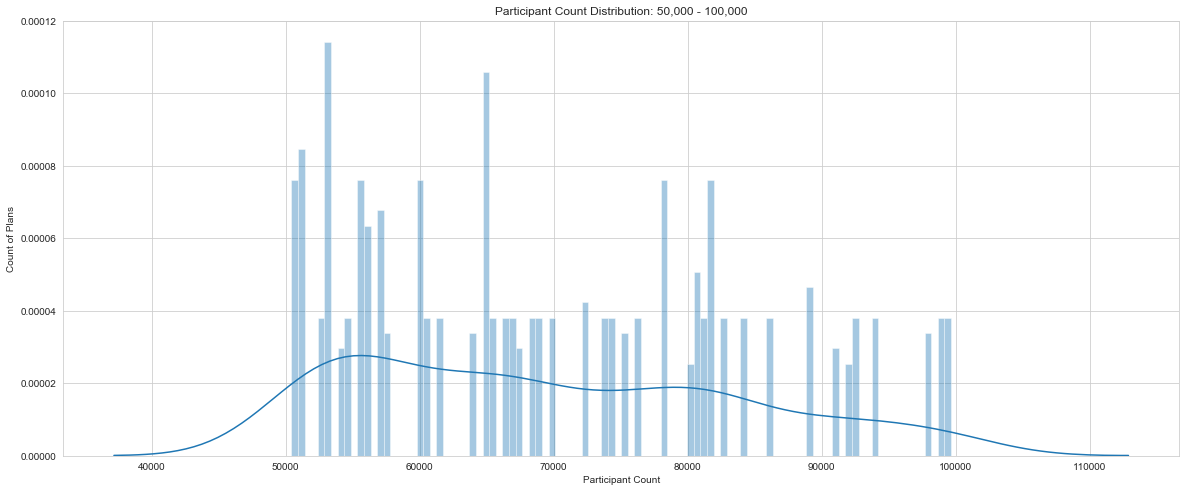

In [41]:
fig, ax = plt.subplots(1,1,figsize=(20,8))
ax = sns.distplot(df[(df['sb_tot_partcp_cnt'] > 50000) & (df['sb_tot_partcp_cnt'] <= 100000)]['sb_tot_partcp_cnt'], bins=100)
plt.title('Participant Count Distribution: 50,000 - 100,000')
plt.xlabel('Participant Count')
plt.ylabel('Count of Plans')
plt.show()

In [42]:
len(df[(df['sb_tot_partcp_cnt'] > 50000) & (df['sb_tot_partcp_cnt'] <= 100000)])

480

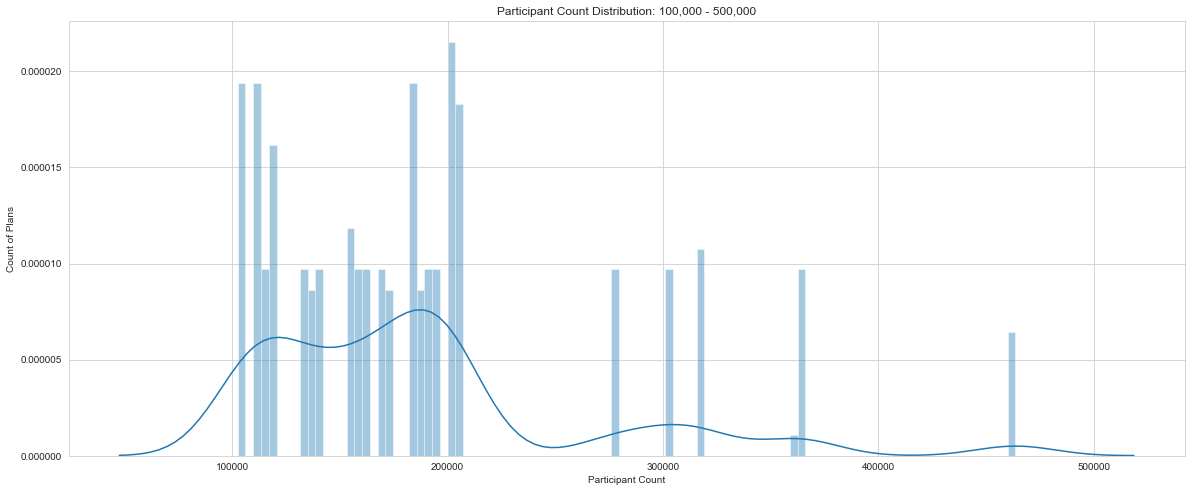

In [43]:
fig, ax = plt.subplots(1,1,figsize=(20,8))
ax = sns.distplot(df[(df['sb_tot_partcp_cnt'] > 100000) & (df['sb_tot_partcp_cnt'] <= 500000)]['sb_tot_partcp_cnt'], bins=100)
plt.title('Participant Count Distribution: 100,000 - 500,000')
plt.xlabel('Participant Count')
plt.ylabel('Count of Plans')
plt.show()

In [44]:
len(df[(df['sb_tot_partcp_cnt'] > 100000) & (df['sb_tot_partcp_cnt'] <= 500000)])

257

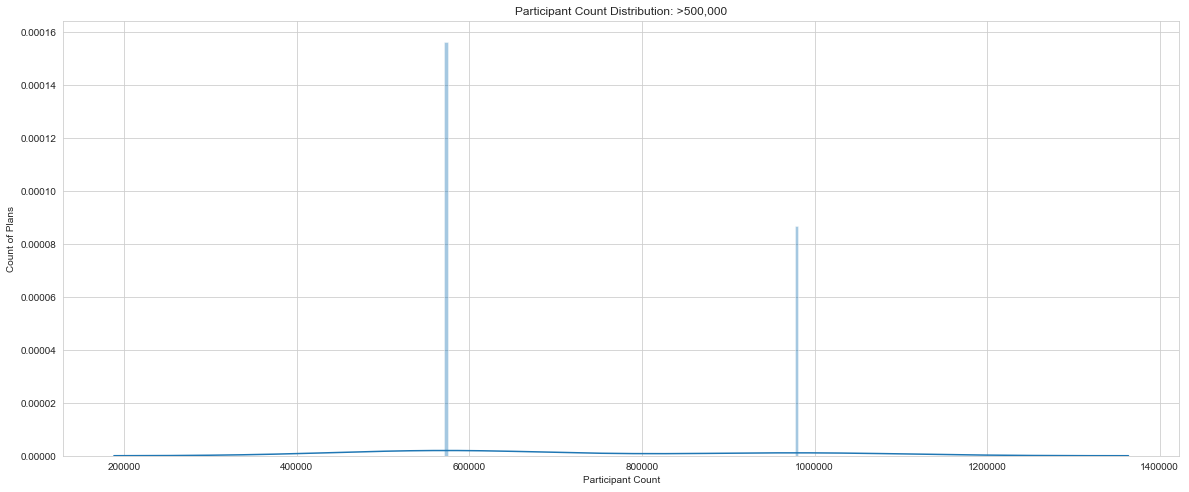

In [45]:
fig, ax = plt.subplots(1,1,figsize=(20,8))
ax = sns.distplot(df[(df['sb_tot_partcp_cnt'] > 500000)]['sb_tot_partcp_cnt'], bins=100)
plt.title('Participant Count Distribution: >500,000')
plt.xlabel('Participant Count')
plt.ylabel('Count of Plans')
plt.show()